# Excitation-Aware Multiplexed Microscopy Simulation

This notebook demonstrates the enhanced SBI simulator with excitation crosstalk modeling and optimization.

In [13]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path

from multiplex_sim.sbi_simulator import SBISimulator, SBIConfig, create_sbi_simulator
from multiplex_sim.plotting import plot_fluorophores
from multiplex_sim.io import list_fluorophores

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

# Configuration
spectra_dir = Path("../data/spectra_npz")
fluorophore_names = ['JF479', 'JF552', 'JF608', 'JFX673', 'JF722']

print(f"Available fluorophores: {list_fluorophores(spectra_dir)}")
print(f"Selected fluorophores: {fluorophore_names}")

Available fluorophores: ['AF488', 'AF514', 'AF532', 'AF546', 'AF555', 'AF561', 'AF594', 'AF610', 'AF633', 'AF647', 'JF479', 'JF525', 'JF552', 'JF608', 'JF722', 'JFX650', 'JFX673', 'NADH - ', 'NADH']
Selected fluorophores: ['JF479', 'JF552', 'JF608', 'JFX673', 'JF722']


## 1. Create Simulators with Different Configurations

In [17]:
# Configuration without excitation crosstalk (simple model)
config_simple = SBIConfig(
    include_excitation_crosstalk=False,
    total_dye_photons=300.0,
    total_background_photons=30.0,
    random_seed=42,
    wavelength_range= (400, 800),
)

# Configuration with excitation crosstalk and optimization
config_excitation = SBIConfig(
    include_excitation_crosstalk=True,
    excitation_wavelengths= [478,554, 603, 673, 727],
    total_dye_photons=300.0,
    total_background_photons=30.0,
    random_seed=42,
    wavelength_range= (400, 800),
)

# Create simulators
simulator_simple = SBISimulator(fluorophore_names, spectra_dir, config_simple)
simulator_excitation = SBISimulator(fluorophore_names, spectra_dir, config_excitation)

print("Simulators created successfully!")
print(f"Simple simulator: excitation crosstalk = {simulator_simple.config.include_excitation_crosstalk}")
print(f"Excitation simulator: excitation crosstalk = {simulator_excitation.config.include_excitation_crosstalk}")
print(f"Optimized excitation wavelengths: {simulator_excitation.excitation_wavelengths}")

Simulators created successfully!
Simple simulator: excitation crosstalk = False
Excitation simulator: excitation crosstalk = True
Optimized excitation wavelengths: [478, 554, 603, 673, 727]


## 2. Visualize Excitation and Emission Spectra

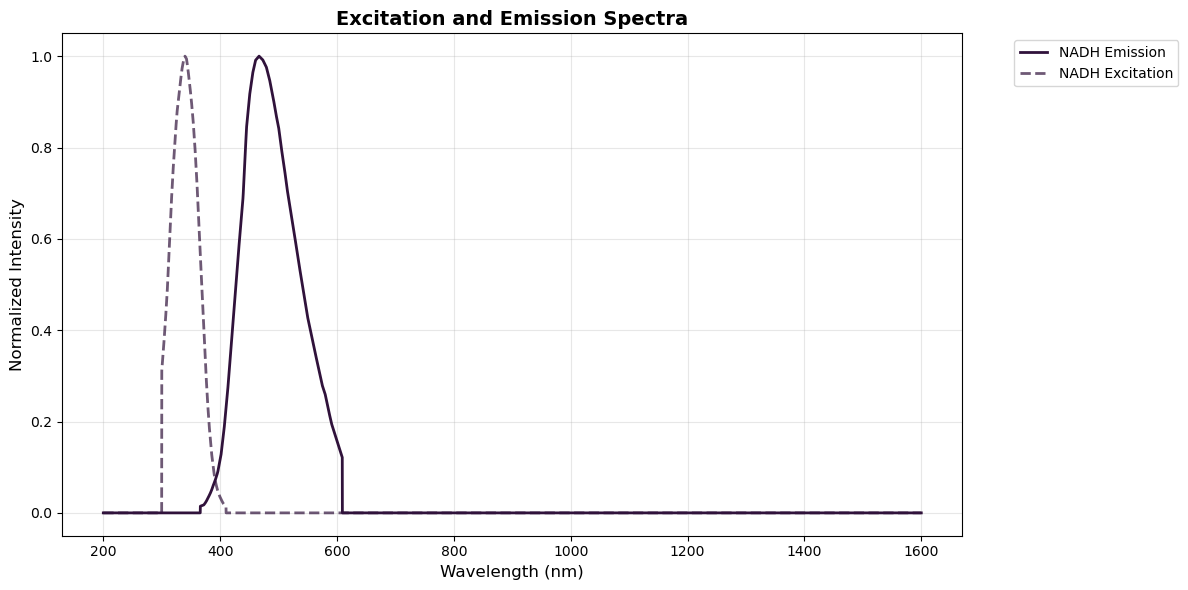

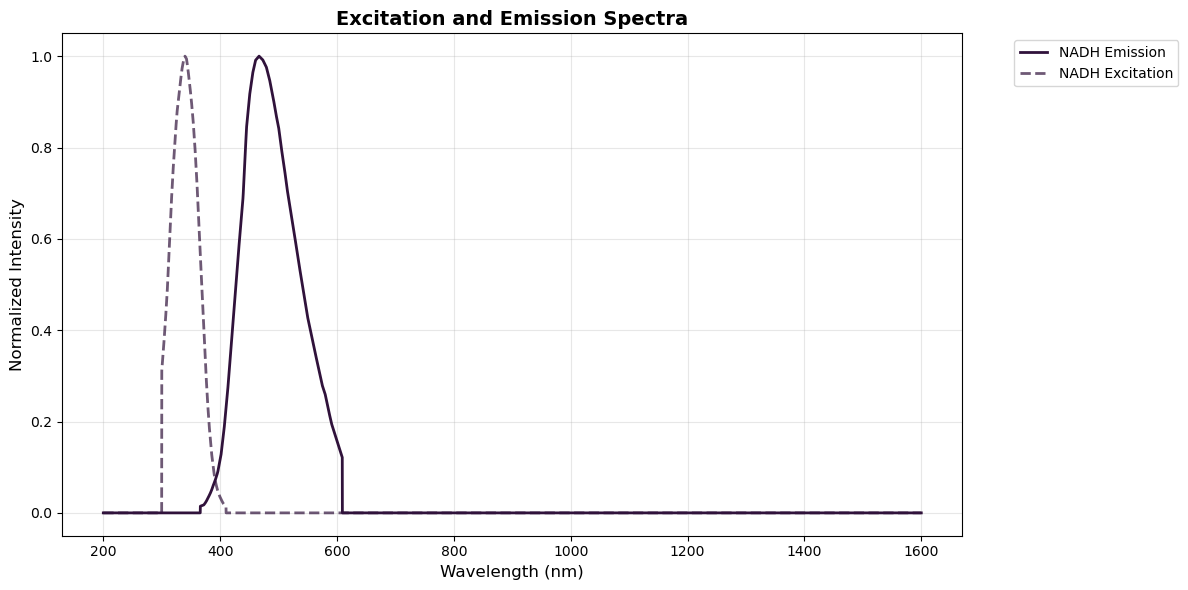

In [18]:

plot_fluorophores(['NADH'], spectra_dir)

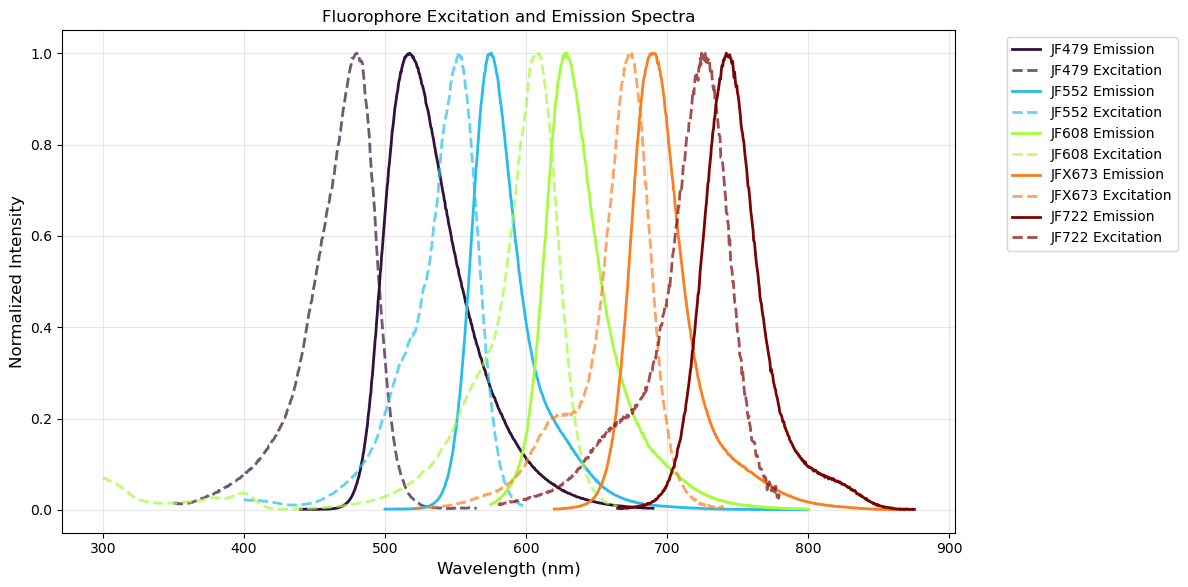

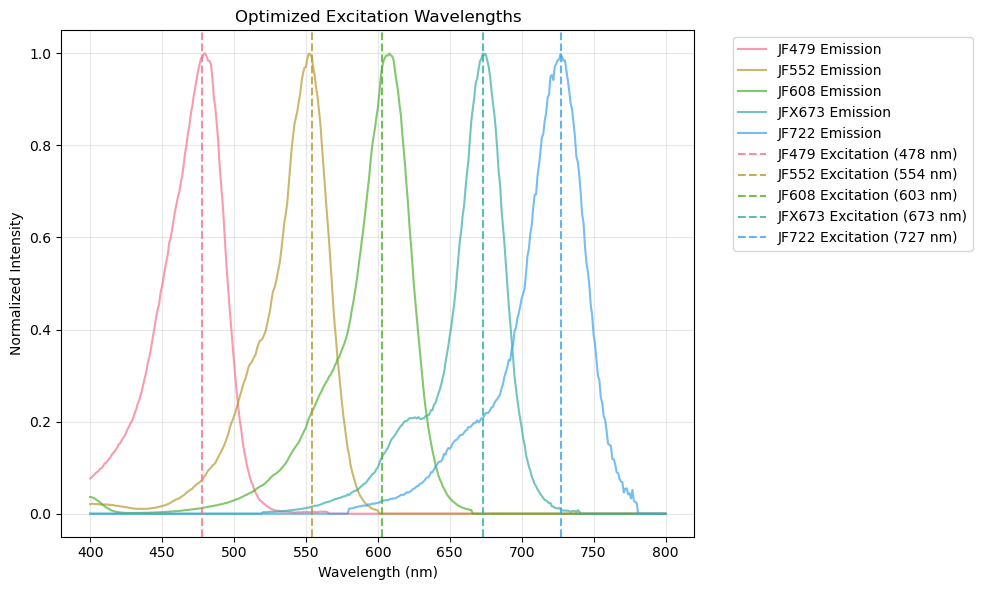

In [19]:
# Plot fluorophore spectra
plot_fluorophores(fluorophore_names, spectra_dir)
plt.title("Fluorophore Excitation and Emission Spectra")
plt.show()

# Show optimized excitation wavelengths
if simulator_excitation.excitation_wavelengths:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot emission spectra
    wavelengths = simulator_excitation.spectra_manager.wavelengths
    for i, name in enumerate(fluorophore_names):
        excitation = simulator_excitation.excitation_spectra[name]
        ax.plot(wavelengths, excitation, label=f"{name} Emission", alpha=0.7)
    
    # Mark optimized excitation wavelengths
    for i, (name, exc_wl) in enumerate(zip(fluorophore_names, simulator_excitation.excitation_wavelengths)):
        ax.axvline(exc_wl, color=f'C{i}', linestyle='--', alpha=0.8, 
                  label=f"{name} Excitation ({exc_wl:.0f} nm)")
    
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Normalized Intensity")
    ax.set_title("Optimized Excitation Wavelengths")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 3. Analyze Excitation Crosstalk Matrix

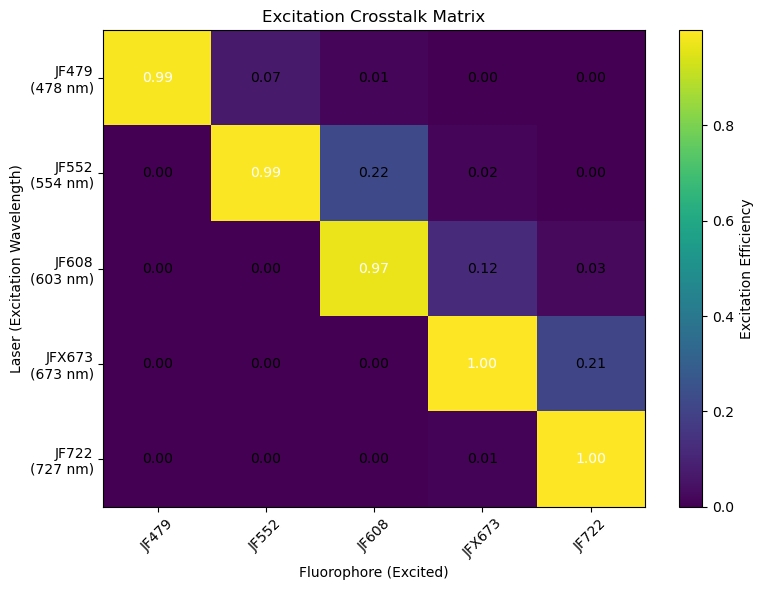


Excitation Crosstalk Analysis:

Laser JF479 (478 nm) excites:
  JF479: 0.99 (100.0% of self-excitation)

Laser JF552 (554 nm) excites:
  JF552: 0.99 (100.0% of self-excitation)
  JF608: 0.22 (22.3% of self-excitation)

Laser JF608 (603 nm) excites:
  JF608: 0.97 (100.0% of self-excitation)
  JFX673: 0.12 (12.7% of self-excitation)

Laser JFX673 (673 nm) excites:
  JFX673: 1.00 (100.0% of self-excitation)
  JF722: 0.21 (20.7% of self-excitation)

Laser JF722 (727 nm) excites:
  JF722: 1.00 (100.0% of self-excitation)


In [20]:
# Calculate and visualize excitation crosstalk matrix
if simulator_excitation.excitation_wavelengths:
    crosstalk_matrix = simulator_excitation.calculate_excitation_crosstalk_matrix()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(crosstalk_matrix, cmap='viridis', aspect='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Excitation Efficiency')
    
    # Set labels
    ax.set_xticks(range(len(fluorophore_names)))
    ax.set_yticks(range(len(fluorophore_names)))
    ax.set_xticklabels(fluorophore_names, rotation=45)
    ax.set_yticklabels([f"{name}\n({wl:.0f} nm)" for name, wl in 
                       zip(fluorophore_names, simulator_excitation.excitation_wavelengths)])
    
    ax.set_xlabel("Fluorophore (Excited)")
    ax.set_ylabel("Laser (Excitation Wavelength)")
    ax.set_title("Excitation Crosstalk Matrix")
    
    # Add text annotations
    for i in range(len(fluorophore_names)):
        for j in range(len(fluorophore_names)):
            text = ax.text(j, i, f'{crosstalk_matrix[i, j]:.2f}',
                          ha="center", va="center", color="white" if crosstalk_matrix[i, j] > 0.5 else "black")
    
    plt.tight_layout()
    plt.show()
    
    # Print crosstalk analysis
    print("\nExcitation Crosstalk Analysis:")
    print("=" * 40)
    for i, (laser_name, laser_wl) in enumerate(zip(fluorophore_names, simulator_excitation.excitation_wavelengths)):
        print(f"\nLaser {laser_name} ({laser_wl:.0f} nm) excites:")
        for j, fluor_name in enumerate(fluorophore_names):
            efficiency = crosstalk_matrix[i, j]
            if efficiency > 0.1:  # Only show significant crosstalk
                print(f"  {fluor_name}: {efficiency:.2f} ({efficiency/crosstalk_matrix[i, i]*100:.1f}% of self-excitation)")

## 4. Compare Simple vs Excitation-Aware Simulations

Simple simulation shape: torch.Size([100, 5])
Excitation simulation shape: torch.Size([100, 5])


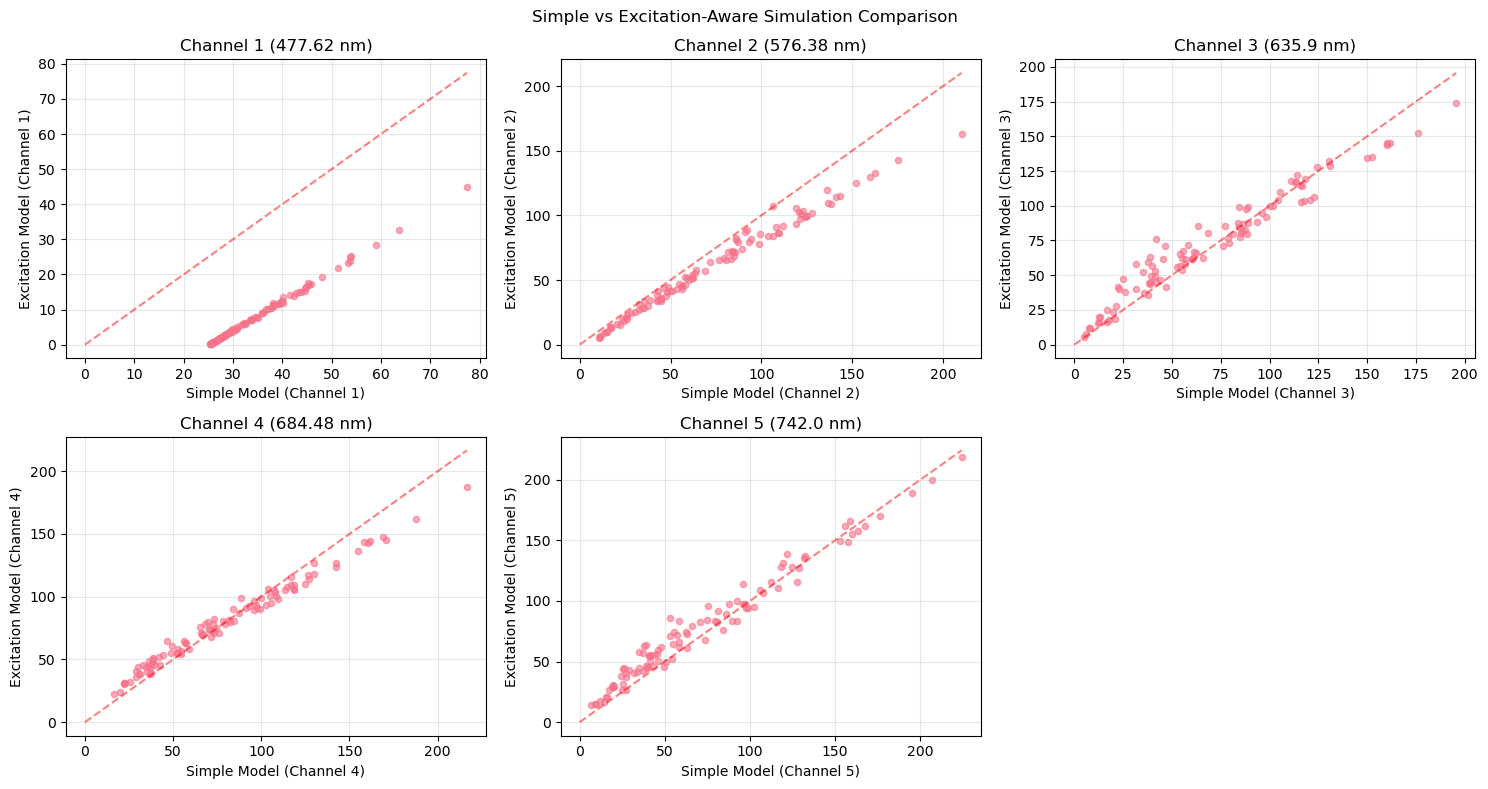

Channel 1 correlation: 0.999
Channel 2 correlation: 0.993
Channel 3 correlation: 0.975
Channel 4 correlation: 0.992
Channel 5 correlation: 0.986

Mean correlation: 0.989


In [22]:
# Define detection filter configuration

bandwidths = np.array([34.21, 22.63, 32.11, 36.32, 36.32])
center_wavelengths = np.array([477.62, 576.38, 635.90, 684.48, 742.00])
# Generate test concentrations
np.random.seed(42)
n_test = 100
test_concentrations = np.random.dirichlet(np.ones(5), size=n_test)

# Simulate with both models
signals_simple = simulator_simple.simulate_batch(
    test_concentrations, center_wavelengths, bandwidths, add_noise=False
)

signals_excitation = simulator_excitation.simulate_batch_with_excitation(
    test_concentrations, center_wavelengths, bandwidths, add_noise=False
)

print(f"Simple simulation shape: {signals_simple.shape}")
print(f"Excitation simulation shape: {signals_excitation.shape}")

# Compare signal distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(5):
    ax = axes[i]
    ax.scatter(signals_simple[:, i], signals_excitation[:, i], alpha=0.6, s=20)
    ax.plot([0, max(signals_simple[:, i].max(), signals_excitation[:, i].max())], 
            [0, max(signals_simple[:, i].max(), signals_excitation[:, i].max())], 
            'r--', alpha=0.5)
    ax.set_xlabel(f"Simple Model (Channel {i+1})")
    ax.set_ylabel(f"Excitation Model (Channel {i+1})")
    ax.set_title(f"Channel {i+1} ({center_wavelengths[i]} nm)")
    ax.grid(True, alpha=0.3)

# Remove empty subplot
axes[5].remove()

plt.suptitle("Simple vs Excitation-Aware Simulation Comparison")
plt.tight_layout()
plt.show()

# Calculate correlation between models
correlations = []
for i in range(5):
    corr = np.corrcoef(signals_simple[:, i], signals_excitation[:, i])[0, 1]
    correlations.append(corr)
    print(f"Channel {i+1} correlation: {corr:.3f}")

print(f"\nMean correlation: {np.mean(correlations):.3f}")

## 5. Background Excitation Effects

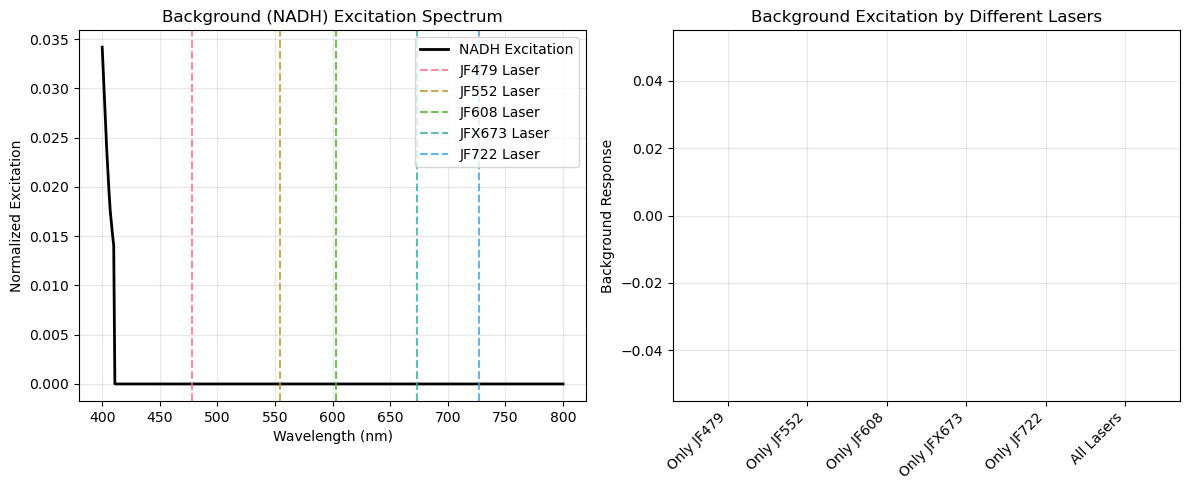

Background excitation responses:
Only JF479: 0.000
Only JF552: 0.000
Only JF608: 0.000
Only JFX673: 0.000
Only JF722: 0.000
All Lasers: 0.000


In [23]:
# Analyze background excitation response
if simulator_excitation.background_excitation is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot background excitation spectrum
    wavelengths = simulator_excitation.spectra_manager.wavelengths
    ax1.plot(wavelengths, simulator_excitation.background_excitation, 'k-', linewidth=2, label='NADH Excitation')
    
    # Mark laser wavelengths
    for i, (name, exc_wl) in enumerate(zip(fluorophore_names, simulator_excitation.excitation_wavelengths)):
        ax1.axvline(exc_wl, color=f'C{i}', linestyle='--', alpha=0.8, label=f"{name} Laser")
    
    ax1.set_xlabel("Wavelength (nm)")
    ax1.set_ylabel("Normalized Excitation")
    ax1.set_title("Background (NADH) Excitation Spectrum")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Calculate background response for different laser combinations
    laser_combinations = [
        [1, 0, 0, 0, 0],  # Only first laser
        [0, 1, 0, 0, 0],  # Only second laser
        [0, 0, 1, 0, 0],  # Only third laser
        [0, 0, 0, 1, 0],  # Only fourth laser
        [0, 0, 0, 0, 1],  # Only fifth laser
        [1, 1, 1, 1, 1],  # All lasers
    ]
    
    bg_responses = []
    labels = [f"Only {name}" for name in fluorophore_names] + ["All Lasers"]
    
    for combo in laser_combinations:
        response = simulator_excitation.calculate_background_excitation_response(
            simulator_excitation.excitation_wavelengths, np.array(combo)
        )
        bg_responses.append(response)
    
    ax2.bar(range(len(bg_responses)), bg_responses, color=['C0', 'C1', 'C2', 'C3', 'C4', 'red'])
    ax2.set_xticks(range(len(labels)))
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.set_ylabel("Background Response")
    ax2.set_title("Background Excitation by Different Lasers")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Background excitation responses:")
    for label, response in zip(labels, bg_responses):
        print(f"{label}: {response:.3f}")
else:
    print("Background excitation spectrum not available")

## 6. Generate Training Data with Excitation Effects

Training data shapes:
Simple: theta torch.Size([1000, 5]), x torch.Size([1000, 5])
Excitation: theta torch.Size([1000, 5]), x torch.Size([1000, 5])


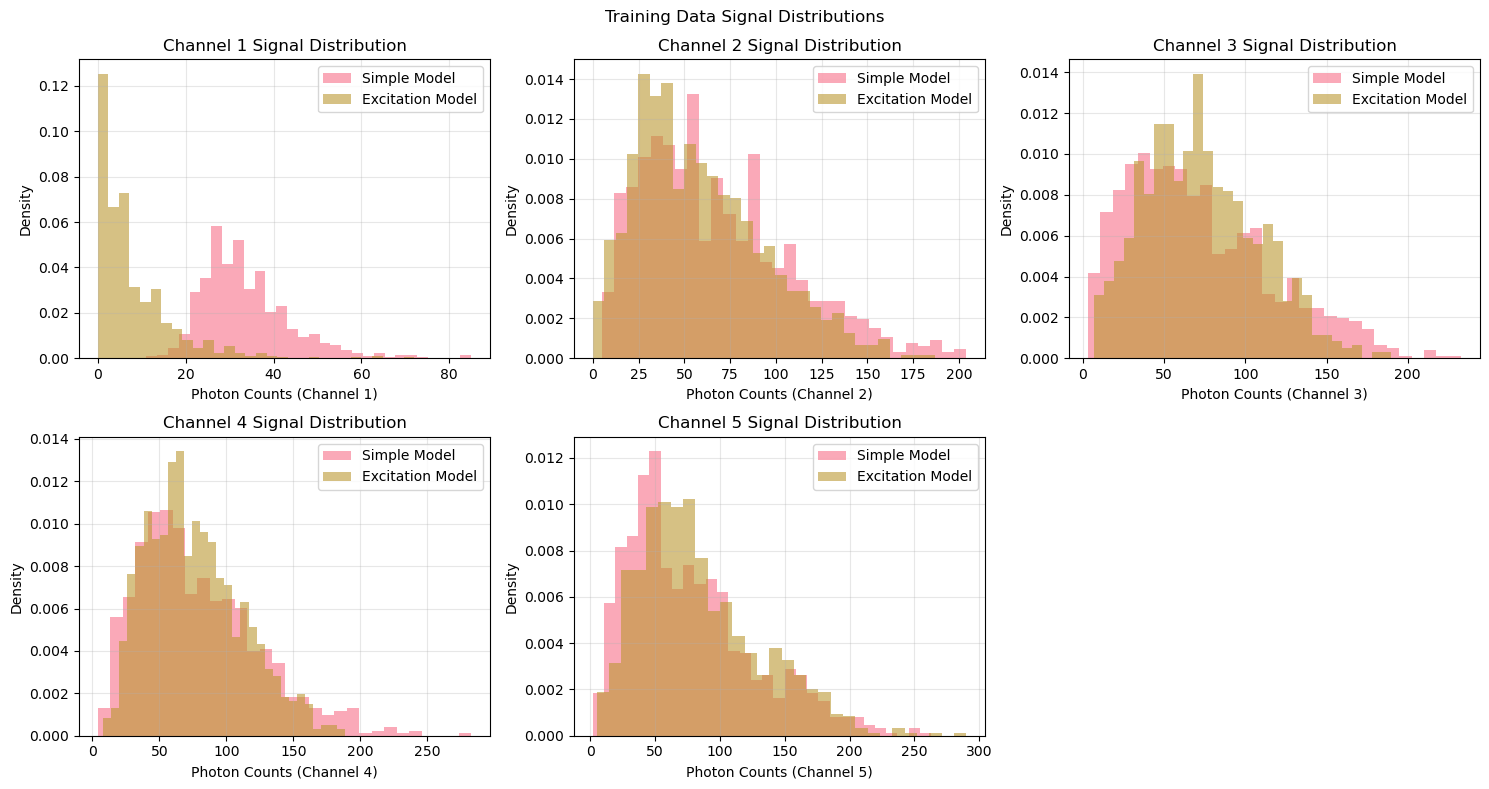


Signal Statistics:
Channel    Simple Mean  Excit Mean   Simple Std   Excit Std   
--------------------------------------------------
1          33.55        7.70         10.07        8.55        
2          67.76        58.61        40.50        34.79       
3          71.32        72.98        44.51        34.78       
4          79.13        76.43        45.07        35.00       
5          77.19        84.03        48.93        46.57       


In [24]:
# Generate training data with both simulators
n_train = 1000

# Simple model training data
theta_simple, x_simple = simulator_simple.generate_training_data(
    n_train, center_wavelengths, bandwidths, prior_type="dirichlet"
)

# Excitation-aware model training data
theta_excitation, x_excitation = simulator_excitation.generate_training_data(
    n_train, center_wavelengths, bandwidths, prior_type="dirichlet"
)

print(f"Training data shapes:")
print(f"Simple: theta {theta_simple.shape}, x {x_simple.shape}")
print(f"Excitation: theta {theta_excitation.shape}, x {x_excitation.shape}")

# Compare signal statistics
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(5):
    ax = axes[i]
    ax.hist(x_simple[:, i].numpy(), bins=30, alpha=0.6, label='Simple Model', density=True)
    ax.hist(x_excitation[:, i].numpy(), bins=30, alpha=0.6, label='Excitation Model', density=True)
    ax.set_xlabel(f"Photon Counts (Channel {i+1})")
    ax.set_ylabel("Density")
    ax.set_title(f"Channel {i+1} Signal Distribution")
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[5].remove()

plt.suptitle("Training Data Signal Distributions")
plt.tight_layout()
plt.show()

# Print signal statistics
print("\nSignal Statistics:")
print("=" * 50)
print(f"{'Channel':<10} {'Simple Mean':<12} {'Excit Mean':<12} {'Simple Std':<12} {'Excit Std':<12}")
print("-" * 50)
for i in range(5):
    simple_mean = x_simple[:, i].mean().item()
    excit_mean = x_excitation[:, i].mean().item()
    simple_std = x_simple[:, i].std().item()
    excit_std = x_excitation[:, i].std().item()
    print(f"{i+1:<10} {simple_mean:<12.2f} {excit_mean:<12.2f} {simple_std:<12.2f} {excit_std:<12.2f}")

## 7. Summary and Insights

In [12]:
print("\n" + "=" * 60)
print("EXCITATION-AWARE SIMULATION SUMMARY")
print("=" * 60)

print(f"\n1. FLUOROPHORES ANALYZED:")
for i, name in enumerate(fluorophore_names):
    print(f"   {name}: Optimized excitation at {simulator_excitation.excitation_wavelengths[i]:.0f} nm")

print(f"\n2. EXCITATION CROSSTALK:")
if simulator_excitation.excitation_wavelengths:
    crosstalk_matrix = simulator_excitation.calculate_excitation_crosstalk_matrix()
    # Calculate off-diagonal crosstalk
    off_diagonal = crosstalk_matrix.copy()
    np.fill_diagonal(off_diagonal, 0)
    max_crosstalk = off_diagonal.max()
    mean_crosstalk = off_diagonal.mean()
    print(f"   Maximum crosstalk: {max_crosstalk:.3f}")
    print(f"   Average crosstalk: {mean_crosstalk:.3f}")

print(f"\n3. BACKGROUND EFFECTS:")
if simulator_excitation.background_excitation is not None:
    single_laser_bg = [simulator_excitation.calculate_background_excitation_response(
        simulator_excitation.excitation_wavelengths, 
        np.eye(5)[i]) for i in range(5)]
    all_laser_bg = simulator_excitation.calculate_background_excitation_response(
        simulator_excitation.excitation_wavelengths, 
        np.ones(5))
    print(f"   Background response range: {min(single_laser_bg):.3f} - {max(single_laser_bg):.3f}")
    print(f"   All lasers background: {all_laser_bg:.3f}")
else:
    print("   Background excitation spectrum not available")

print(f"\n4. SIMULATION DIFFERENCES:")
signal_diff = (x_excitation - x_simple).abs().mean(dim=0)
for i, diff in enumerate(signal_diff):
    print(f"   Channel {i+1}: Mean absolute difference = {diff:.2f} photons")

print(f"\n5. RECOMMENDATIONS:")
print(f"   - Use excitation-aware simulation for accurate modeling")
print(f"   - Consider crosstalk effects in experimental design")
print(f"   - Optimize laser powers to minimize background")
print(f"   - Validate SBI models with both simulation approaches")

print("\n" + "=" * 60)


EXCITATION-AWARE SIMULATION SUMMARY

1. FLUOROPHORES ANALYZED:
   JF525: Optimized excitation at 519 nm
   JF552: Optimized excitation at 554 nm
   JF608: Optimized excitation at 603 nm
   JFX673: Optimized excitation at 673 nm
   JF722: Optimized excitation at 727 nm

2. EXCITATION CROSSTALK:
   Maximum crosstalk: 0.377
   Average crosstalk: 0.046

3. BACKGROUND EFFECTS:
   Background response range: 0.000 - 0.000
   All lasers background: 0.000

4. SIMULATION DIFFERENCES:
   Channel 1: Mean absolute difference = 42.33 photons
   Channel 2: Mean absolute difference = 32.41 photons
   Channel 3: Mean absolute difference = 37.00 photons
   Channel 4: Mean absolute difference = 41.38 photons
   Channel 5: Mean absolute difference = 47.72 photons

5. RECOMMENDATIONS:
   - Use excitation-aware simulation for accurate modeling
   - Consider crosstalk effects in experimental design
   - Optimize laser powers to minimize background
   - Validate SBI models with both simulation approaches

